<div style="background:#FFFFAA">
<img src="./logo.jpg", width=150, ALIGN="left", border=20>
<h1>L2RPN Starting Kit </h1> 

<br>This code was tested with <br>
Python 3.6.6 |Anaconda custom (64-bit)| (default, Nov 2018, 11:07:29) (https://anaconda.org/)<br>
<i> Adapted for Chalab by Isabelle Guyon from original code of Balázs Kégl</i> <br>
<a href="http://www.datascience-paris-saclay.fr">Paris Saclay Center for Data Science (CDS)</a>
</center>
<p>
ALL INFORMATION, SOFTWARE, DOCUMENTATION, AND DATA ARE PROVIDED "AS-IS". The CDS, CHALEARN, AND/OR OTHER ORGANIZERS OR CODE AUTHORS DISCLAIM ANY EXPRESSED OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR ANY PARTICULAR PURPOSE, AND THE WARRANTY OF NON-INFRIGEMENT OF ANY THIRD PARTY'S INTELLECTUAL PROPERTY RIGHTS. IN NO EVENT SHALL AUTHORS AND ORGANIZERS BE LIABLE FOR ANY SPECIAL, 
INDIRECT OR CONSEQUENTIAL DAMAGES OR ANY DAMAGES WHATSOEVER ARISING OUT OF OR IN CONNECTION WITH THE USE OR PERFORMANCE OF SOFTWARE, DOCUMENTS, MATERIALS, PUBLICATIONS, OR INFORMATION MADE AVAILABLE FOR THE CHALLENGE. 
</div>

<div style="background:#FFFFAA">
    <h2>Introduction </h2>
    <p> 
     <br>
The goal of this challenge is to use Reinforcement Learning in Power Grid management by designing RL agents to automate the control of the power grid. The dataset used in this challenge is from <a href="https://github.com/MarvinLer/pypownet">pypownet</a>, made by Marvin Lerousseau, it is a simulator that is able to emulate a power grid of any size and electrical properties subject to a set of temporal injections for discretized time-steps.

References and credits: <br>
Founder of pypownet was Marvin Lerousseau. The competition protocol was designed by Isabelle Guyon. Our mentors are Balthazar Donon and Antoine Marot. Pypownet, 2017. https://github.com/MarvinLer/pypownet. The baseline methods were inspired by work performed by Kimang Khun.
 <br> 
</div>

In [1]:
model_dir = 'example_submission/'
problem_dir = 'ingestion_program/'  
score_dir = 'scoring_program/'
input_dir = 'public_data/'
output_dir = 'output/'
from sys import path; path.append(model_dir); path.append(problem_dir); path.append(score_dir);
path.append(input_dir); path.append(output_dir);
%matplotlib inline
# Uncomment the next lines to auto-reload libraries (this causes some problem with pickles in Python 3)
%load_ext autoreload
%autoreload 2
import seaborn as sns; sns.set()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

<div style="background:#FFFFAA">
    <h1> Step 1: Exploratory data analysis </h1>
<p>
We provide data with the starting kit.
    <br>
</div>

## Electrical grid
<div >
<img src="./ExampleGrid.JPG", width=750, ALIGN="left", border=20>
    <br>
    <br>
(courtesy of Marvin Lerousseau)
</div>

During the challenge, a grid of 14 substations is given. 20 lines connected the nodes of the network.

For the following example, we take the case where there are 11 loads and 5 prods and particularly the hard level. Furthermore, the information shown are only those of January.

In [2]:
data_dir = 'sample_data/hard'              # Change this to the directory where you put the input data
!ls $data_dir*

chronics  configuration.yaml  reference_grid.m


For convenience, we load the data as a "pandas" data frame, so we can use "pandas" to explore the data.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

loads_p_file = '_N_loads_p.csv'
prods_p_file = '_N_prods_p.csv'
datetimes_file = '_N_datetimes.csv'
maintenance_file = 'maintenance.csv'
hazards_file = 'hazards.csv'
imaps_file = '_N_imaps.csv'
df_loads_p = {}
df_prods_p = {}
df_datetimes = {}
df_maintenance = {}
df_hazards = {} 
i = 0 # chronics id

path = data_dir+'/chronics/'+str(i)+'/'
df_loads_p[str(i)] = pd.read_csv(path+loads_p_file, sep=';')
df_prods_p[str(i)] = pd.read_csv(path+prods_p_file, sep=';')
df_datetimes[str(i)] = pd.read_csv(path+datetimes_file, sep=';')
df_loads_p[str(i)].index = pd.to_datetime(df_datetimes[str(i)]['date'] + ' ' + df_datetimes[str(i)]['time'])
df_prods_p[str(i)].index = pd.to_datetime(df_datetimes[str(i)]['date'] + ' ' + df_datetimes[str(i)]['time'])
df_maintenance[str(i)] = pd.read_csv(path+maintenance_file, sep=';')
df_maintenance[str(i)].index = pd.to_datetime(df_datetimes[str(i)]['date'] + ' ' + df_datetimes[str(i)]['time'])
df_hazards[str(i)] = pd.read_csv(path+hazards_file, sep=';')
df_hazards[str(i)].index = pd.to_datetime(df_datetimes[str(i)]['date'] + ' ' + df_datetimes[str(i)]['time'])
df_imaps = pd.read_csv(path + imaps_file, sep=';')

## Loads

The following figure shows the active power of consumptions which represents the amount of demand of active power. This information appears in the \_N\_loads\_p.csv. Note that the power needed is cyclic during the day. In our particular case, the load 3_C151.15 is the one which needs power the most power. The loads for the other levels are pretty similar with a load needing much more power than the others.

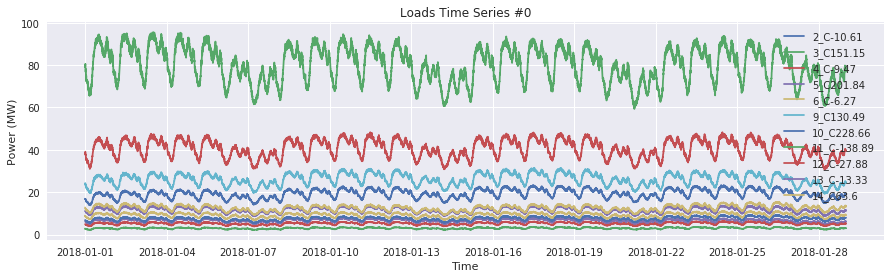

In [4]:
plt.figure(figsize=[15,4])
plt.title('Loads Time Series #'+str(0))
plt.xlabel('Time')
plt.ylabel('Power (MW)')
plt.plot(df_loads_p[str(0)])
plt.legend(list(df_loads_p[str(0)]))
plt.show()

## Production

The active power of the productions is shown below. In the easy mode, each one of them is stable contrary to the medium and hard modes where the productions are much more heterogeneous.

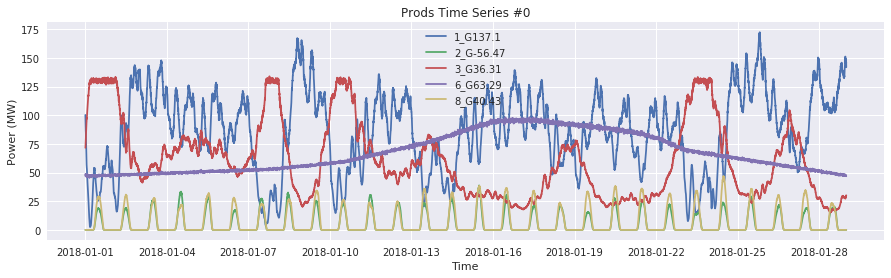

In [5]:
plt.figure(figsize=[15,4])
plt.title('Prods Time Series #'+str(0))
plt.xlabel('Time')
plt.ylabel('Power (MW)')
plt.plot(df_prods_p[str(0)])
plt.legend(list(df_prods_p[str(0)]))
plt.show()

## Maintenance

Maintenance exist only for the hard mode. When a maintenance happens for a production, the voltage magnitudes of the associated production is set to 0 in \_N\_prods\_v.csv for a number of timesteps. Here, two maintenances happen in January.

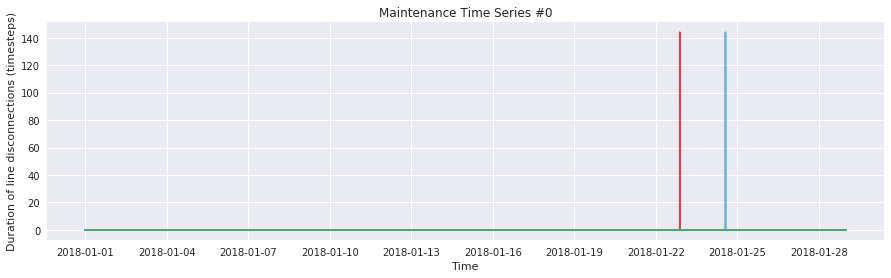

In [6]:
plt.figure(figsize=[15,4])
plt.title('Maintenance Time Series #'+str(0))
plt.xlabel('Time')
plt.ylabel('Duration of line disconnections (timesteps)')
plt.plot(df_maintenance[str(0)])
plt.show()

## Hazard

Again, hazards only happen with the hard mode. They represent external events that break lines from time to time, be it natural hazards or ones related to the network itself.

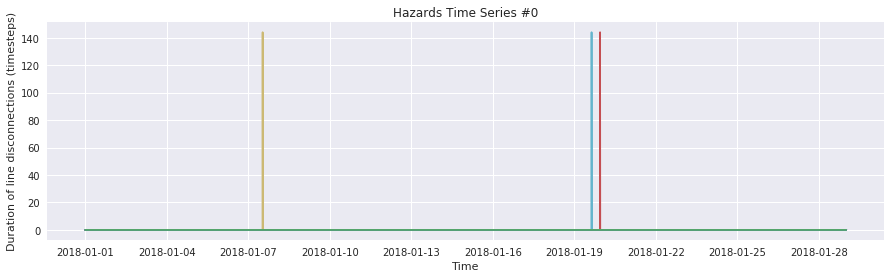

In [7]:
plt.figure(figsize=[15,4])
plt.title('Hazards Time Series #'+str(0))
plt.xlabel('Time')
plt.ylabel('Duration of line disconnections (timesteps)')
plt.plot(df_hazards[str(0)])
plt.show()

<div style="background:#FFFFAA">
<h1>Step 2: Building an Agent</h1>
</div>

<div style="background:#FFFFAA">
    <h2>Loading data with pypownet</h2>
    <p>
We reload the data with the environment class of pypownet
   <br>
    
To win, flows in a line have to stay under a threshold. Above this threshold, the line will overheat and after a certain amount of overheating, the line will break. Thermal limits are already defined in pypownet.
</div>

In [8]:
import os
import pypownet.environment
import pypownet.runner
data_dir = 'sample_data'  
environment = pypownet.environment.RunEnv(parameters_folder=os.path.abspath(data_dir),
                                              game_level="hard",
                                              chronic_looping_mode='natural', start_id=0,
                                              game_over_mode="soft")

Using custom reward signal CustomRewardSignal of file /home/aux/sample_data/reward_signal.py



                     GAME PARAMETERS
    hard_overflow_coefficient: 1.0
    loadflow_backend: pypower
    loadflow_mode: AC
    max_number_loads_game_over: 6
    max_number_prods_game_over: 3
    max_seconds_per_timestep: 1.0
    n_timesteps_consecutive_soft_overflow_breaks: 10
    n_timesteps_hard_overflow_is_broken: 10
    n_timesteps_horizon_maintenance: 48
    n_timesteps_soft_overflow_is_broken: 10



<div style="background:#FFFFAA">
    <h2>Building an agent</h2>
    <p>
We provide examples of agent (for reinforcement learning) in the `starting-kit/example_submission` directory. It is a quite stupid agent: it does nothing. Replace it with your own agent.
    </div>

## Do nothing agent

The agent does not take any actions.

In [9]:
import pypownet.agent
import pypownet.environment


class DoNothingAgent(pypownet.agent.Agent):
    def __init__(self, environment):
        super().__init__(environment)

    def act(self, observation):
        """ Produces an action given an observation of the environment. Takes as argument an observation of the current
        power grid, and returns the chosen action."""
        # Sanity check: an observation is a structured object defined in the environment file.
        assert isinstance(observation, pypownet.environment.Observation)

        action_space = self.environment.action_space

        # Implement your policy here
        # Example of the do-nothing policy that produces no action (i.e. an action that does nothing) each time
        do_nothing_action = action_space.get_do_nothing_action()

        # Sanity check: verify the good overall structure of the returned action; raises exceptions if not valid
        assert action_space.verify_action_shape(do_nothing_action)
        return do_nothing_action


In [10]:
import baseline_agents
# Uncomment the next line to display the code of the DoNothing Agent
#??baseline_agents.DoNothingAgent

## RandomLineSwitch agent
The agent randomly switches the status of one random power line per timestep (if the random line is previously online, switch it off, otherwise switch it on

In [11]:
import baseline_agents
# Uncomment the next line to display the code of the RandomLineSwitch Agent
#??baseline_agents.RandomLineSwitch

## RandomNodeSplitting agent
The agent selects a random switch configuration such that switched elements of the selected substations change the node within the substation on which they are directly wired.

In [12]:
import baseline_agents
# Uncomment the next line to display the code of the RandomNodeSplitting Agent
#??baseline_agents.RandomNodeSplitting

<div style="background:#FFFFAA">
an instance of the agent (run the constructor) and attempt to reload a previously saved version from `starting_kit/example_submission/`:
    
</div>

## Scoring the results of an agent

<div style="background:#FFFFAA">
    <br>
    <p>
<b>The metric chosen for your challenge</b> is identified in the "metric.txt" file found in the `scoring_function/` directory. The function "get_metric" searches first for a metric having that name in my_metric.py, then in libscores.py, then in sklearn.metric.
    <br>
The aim of a reinforcement learning problem is to maximize the reward function.

When running the agent, two values are given back : the first one is the reward of the last timestep and the second one is the cumulative reward for all the iterations of the run of the agent. The reward indicates if the game is going towards a game over or not.

Specifically, our reward function is composed of 5 subrewards. They describe the proportion of isolated productions, loads, the cost of an action, an indication of the amount of changes between the current grid and the initial grid and lastly information on the lines capacity usage. 
    </div>

In [13]:
from libscores import get_metric
metric_name, scoring_function = get_metric()
print('Using scoring metric:', metric_name)
# Uncomment the next line to display the code of the scoring metric
#??scoring_function

Using scoring metric: reward


### Run the Do nothing agent

In [14]:
import logging
import sys
NUMBER_ITERATIONS = 50 # The number of iterations can be changed

submission_dir = 'example_submission'
sys.path.append(submission_dir)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
log_path = os.path.abspath(os.path.join(output_dir, 'runner.log'))


open(log_path, 'w').close()
submitted_controler = baseline_agents.DoNothingAgent(environment)
# Instanciate a runner, that will save the run statistics within the log_path file, to be parsed and processed
# by the scoring program
phase_runner = pypownet.runner.Runner(environment, submitted_controler, verbose=True, vverbose=False,
                                      log_filepath=log_path)
phase_runner.ch.setLevel(logging.ERROR)
# Run the planned experiment of this phase with the submitted model
score = phase_runner.loop(iterations=NUMBER_ITERATIONS)
print("cumulative rewards : {}".format(score))

cumulative rewards : -11.269334237132293


In [15]:
#get the score with the scoring_function
scoring_function(output_dir)

step : 50, cumulative rewards : -11.27


### Run the RandomLineSwitch agent

In [16]:
import logging
import sys
NUMBER_ITERATIONS = 50

submission_dir = 'example_submission'
sys.path.append(submission_dir)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
log_path = os.path.abspath(os.path.join(output_dir, 'runner.log'))


open(log_path, 'w').close()
submitted_controler = baseline_agents.RandomLineSwitch(environment)
# Instanciate a runner, that will save the run statistics within the log_path file, to be parsed and processed
# by the scoring program
phase_runner = pypownet.runner.Runner(environment, submitted_controler, verbose=True, vverbose=False,
                                      log_filepath=log_path)
phase_runner.ch.setLevel(logging.ERROR)
# Run the planned experiment of this phase with the submitted model
score = phase_runner.loop(iterations=NUMBER_ITERATIONS)
print("cumulative rewards : {}".format(score))

reward: [ -0.00, -0.00, 0.20, -0.00, -0.13 ] = 0.07467970689100889
Action chosen:  switching status of line 12 ; expected reward 0.0747
reward: [ -0.00, -0.00, 0.20, -0.00, -0.13 ] = 0.07259221929176835
Action chosen:  switching status of line 7 ; expected reward 0.0726
reward: [ -0.00, -0.00, 0.20, -0.00, -0.13 ] = 0.07231324254524357
Action chosen:  switching status of line 4 ; expected reward 0.0723
reward: [ -0.00, -0.00, 0.20, -0.00, -0.15 ] = 0.04684402683345257
Action chosen:  switching status of line 10 ; expected reward 0.0468
reward: [ -0.00, -1.40, 0.20, -0.00, -0.15 ] = -1.3530112540610322
Action chosen:  switching status of line 13 ; expected reward -1.3530
reward: [ -0.00, -1.40, 0.20, -0.00, -0.15 ] = -1.3536219439201367
Action chosen:  switching status of line 4 ; expected reward -1.3536
reward: [ 0.00, 0.00, 0.20, -14.00, 0.00 ] = -13.8
Action chosen:  switching status of line 16 ; expected reward -13.8000
reward: [ -0.00, -0.00, 0.20, -0.00, -0.12 ] = 0.08193953272304

/opt/conda/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:192: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


reward: [ 0.00, 0.00, 0.20, -14.00, 0.00 ] = -13.8
Action chosen:  switching status of line 12 ; expected reward -13.8000
reward: [ -0.00, -0.00, 0.20, -0.00, -0.11 ] = 0.09424948648439996
Action chosen:  switching status of line 18 ; expected reward 0.0942
reward: [ -0.00, -0.00, 0.20, -0.00, -0.10 ] = 0.09555499404752127
Action chosen:  switching status of line 18 ; expected reward 0.0956
reward: [ -0.00, -0.00, 0.20, -0.00, -0.11 ] = 0.08733499023360516
Action chosen:  switching status of line 11 ; expected reward 0.0873
reward: [ -0.00, -0.00, 0.20, -0.00, -0.12 ] = 0.08208511518510196
Action chosen:  switching status of line 6 ; expected reward 0.0821
reward: [ -0.00, -0.00, 0.20, -0.00, -0.12 ] = 0.08104828703304699
Action chosen:  switching status of line 4 ; expected reward 0.0810
reward: [ -0.00, -0.00, 0.20, -0.00, -0.13 ] = 0.0729500344216624
Action chosen:  switching status of line 16 ; expected reward 0.0730
reward: [ -2.80, -0.00, 0.20, -0.00, -0.13 ] = -2.725778688199673

In [17]:
#get the score with the scoring_function
scoring_function(output_dir)

step : 50, cumulative rewards : -145.56


### Run the RandomNodeSplitting agent

In [18]:
import logging
import sys
NUMBER_ITERATIONS = 50

submission_dir = 'example_submission'
sys.path.append(submission_dir)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
log_path = os.path.abspath(os.path.join(output_dir, 'runner.log'))


open(log_path, 'w').close()
submitted_controler = baseline_agents.RandomNodeSplitting(environment)
# Instanciate a runner, that will save the run statistics within the log_path file, to be parsed and processed
# by the scoring program
phase_runner = pypownet.runner.Runner(environment, submitted_controler, verbose=True, vverbose=False,
                                      log_filepath=log_path)
phase_runner.ch.setLevel(logging.ERROR)
# Run the planned experiment of this phase with the submitted model
score = phase_runner.loop(iterations=NUMBER_ITERATIONS)
print("cumulative rewards : {}".format(score))

reward: [ -0.00, -0.00, 0.40, -0.08, -0.20 ] = 0.1158888018676765
Action chosen:  change in topo of sub. 6 with switches array([1, 0, 1, 1, 1, 0]) ; expected reward 0.1159
reward: [ -0.00, -0.00, 0.00, -0.08, -0.20 ] = -0.2803033150289772
Action chosen:  change in topo of sub. 10 with switches array([0, 0, 0]) ; expected reward -0.2803
reward: [ -0.00, -0.00, 0.10, -0.10, -0.20 ] = -0.1966293245366711
Action chosen:  change in topo of sub. 5 with switches array([0, 0, 1, 0, 0]) ; expected reward -0.1966
reward: [ -0.00, -0.00, 0.30, -0.16, -0.26 ] = -0.11969867250927455
Action chosen:  change in topo of sub. 4 with switches array([0, 0, 0, 1, 1, 1]) ; expected reward -0.1197
reward: [ -0.00, -0.00, 0.20, -0.20, -0.25 ] = -0.25061957434465093
Action chosen:  change in topo of sub. 12 with switches array([1, 0, 1]) ; expected reward -0.2506
reward: [ 0.00, 0.00, 0.30, -14.00, 0.00 ] = -13.7
Action chosen:  change in topo of sub. 13 with switches array([1, 0, 1, 1]) ; expected reward -13.

/opt/conda/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:192: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


reward: [ -2.80, -0.00, 0.10, -0.14, -0.13 ] = -2.969065873448752
Action chosen:  change in topo of sub. 14 with switches array([1, 0, 0]) ; expected reward -2.9691
reward: [ -2.80, -0.00, 0.10, -0.16, -0.17 ] = -3.028246132034253
Action chosen:  change in topo of sub. 9 with switches array([0, 0, 0, 0, 1]) ; expected reward -3.0282
reward: [ -5.60, -0.00, 0.20, -0.16, -0.16 ] = -5.715071964478228
Action chosen:  change in topo of sub. 10 with switches array([1, 1, 0]) ; expected reward -5.7151
reward: [ -8.40, -0.00, 0.10, -0.14, -0.16 ] = -8.596161540793673
Action chosen:  change in topo of sub. 12 with switches array([0, 1, 0]) ; expected reward -8.5962
reward: [ -8.40, -0.00, 0.20, -0.18, -0.15 ] = -8.533436600416895
Action chosen:  change in topo of sub. 11 with switches array([1, 1, 0]) ; expected reward -8.5334
reward: [ -8.40, -0.00, 0.20, -0.22, -0.91 ] = -9.326314101396108
Action chosen:  change in topo of sub. 4 with switches array([1, 1, 0, 0, 0, 0]) ; expected reward -9.32

In [19]:
#get the score with the scoring_function
scoring_function(output_dir)

step : 50, cumulative rewards : -180.86


<div style="background:#FFFFAA">
    <b> Save the best agent </b> it should be a class Submission and save in "example_submission/submission.py".  Uncomment the line <i>%%writefile example_submission/submission.py to save the agent. </i>
</div>

In [20]:
#%%writefile example_submission/submission.py
import pypownet.agent
import pypownet.environment

class Submission(pypownet.agent.Agent):
    def __init__(self, environment):
        super().__init__(environment)

    def act(self, observation):
        """ Produces an action given an observation of the environment. Takes as argument an observation of the current
        power grid, and returns the chosen action."""
        # Sanity check: an observation is a structured object defined in the environment file.
        assert isinstance(observation, pypownet.environment.Observation)

        action_space = self.environment.action_space

        # Implement your policy here
        # Example of the do-nothing policy that produces no action (i.e. an action that does nothing) each time
        do_nothing_action = action_space.get_do_nothing_action()

        # Sanity check: verify the good overall structure of the returned action; raises exceptions if not valid
        assert action_space.verify_action_shape(do_nothing_action)
        return do_nothing_action

<div style="background:#FFFFAA">
<h1> Step 3: Making a submission </h1> 

<h2> Unit testing </h2> 

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. All you have to do to make a submission is modify the file <code>submission.py</code> in the <code>starting_kit/example_submission/</code> directory, then run this test to make sure everything works fine. This is the actual program that will be run on the server to test your submission. 
<br>
Keep the sample code simple.
</div>

In [21]:
!python $problem_dir/ingestion.py $input_dir $input_dir/res $problem_dir $model_dir

input dir: /home/aux/public_data
output dir: /home/aux/public_data/res
program dir: /home/aux/ingestion_program
submission dir: /home/aux/example_submission
input content ['__pycache__', 'medium', 'hard', 'easy', 'level0', 'reward_signal.py', 'res']
output content ['runner.log']
program content ['data_manager.py', 'data_converter.py', '__pycache__', 'data_io.py', 'metadata', 'ingestion.py']
submission content ['__pycache__', 'baseline_agents.py', 'metadata', 'submission.py']
Using custom reward signal CustomRewardSignal of file /home/aux/public_data/reward_signal.py

                     GAME PARAMETERS
    hard_overflow_coefficient: 1.0
    loadflow_backend: pypower
    loadflow_mode: AC
    max_number_loads_game_over: 6
    max_number_prods_game_over: 3
    max_seconds_per_timestep: 1.0
    n_timesteps_consecutive_soft_overflow_breaks: 10
    n_timesteps_hard_overflow_is_broken: 10
    n_timesteps_horizon_maintenance: 48
    n_timesteps_soft_overflow_is_broken: 10

log file path /hom

<div style="background:#FFFFAA">
Also test the scoring program:
    </div>

In [22]:
scoring_output_dir = 'output'
!python $score_dir/evaluate.py $input_dir $scoring_output_dir

public_data/
output
step : 1000, cumulative rewards : -453.92


<div style="background:#FFFFAA">
    <h1> Preparing the submission </h1>

Zip the contents of `sample_code_submission/` (without the directory), or download the challenge public_data and run the command in the previous cell, after replacing sample_data by public_data.
Then zip the contents of `sample_result_submission/` (without the directory).
<b><span style="color:red">Do NOT zip the data with your submissions</span></b>.

In [23]:
import datetime 
from data_io import zipdir
the_date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
sample_code_submission = 'sample_code_submission_' + the_date + '.zip' 
zipdir(sample_code_submission, model_dir) 
print("Submit one of these files:\n" + sample_code_submission + "\n")

Submit one of these files:
sample_code_submission_19-01-23-19-07.zip

